In [1]:
import numpy as np
import pandas as pd
import copy

from src.workflow_manager.paths import data_path, ruleset_path
from src.pipelines.load_and_transform_pipeline import load_and_transform



# ML 
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, roc_auc_score, roc_curve

from src.modelling.model_functions import build_model
from src.modelling.basemodel import base_model
from src.modelling.model_functions import sigmoid, get_plot_data
from src.modelling.model_plots import plot_model_field





pd.set_option('display.max_columns',None)


### <font color='#f88231'>Load Data and create empty Train Test split DFs</font>


In [2]:
# we need the original Data to generate the column_manager
data_original = load_and_transform(data_path, ruleset_path)

data = data_original.copy()
data['const'] = 1


# empty datasets
X_train, X_test, y_train, y_test = train_test_split(data[['contract_nr', 'const']],data[['contract_nr', 'payment_fault']].set_index('contract_nr'),test_size=0.3, random_state=42)

tts_list = [X_train, X_test, y_train, y_test ]

## <font color='#f88231'>Fit Base Model</font>


In [3]:
# Save the different columns here
column_manager = {'original' : list(data_original.columns)}
erg = build_model(data, column_manager=column_manager, group_file=base_model , tts_list=tts_list )
print(erg['model'].summary())
#plot_model_field(erg, erg['column_manager']['plots'],on_test_data=False)

                 Generalized Linear Model Regression Results                  
Dep. Variable:          payment_fault   No. Observations:                19562
Model:                            GLM   Df Residuals:                    19521
Model Family:                Binomial   Df Model:                           40
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -6907.1
Date:                Fri, 13 Oct 2023   Deviance:                       13814.
Time:                        22:14:18   Pearson chi2:                 1.95e+04
No. Iterations:                     6   Pseudo R-squ. (CS):             0.1859
Covariance Type:            nonrobust                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -2.87

## <font color='#f88231'>Improve the Model</font>
Some of the features correlate highly, so the model is not very good. 

**Steps**
1. improve the main Mistakes by regrouping and excluding fields that are not necessary.
> age insured person and SF Classes are correlated. we exclude the VK, because this value is not correct for KH and TK customers




copy the base_model and change the rules. 

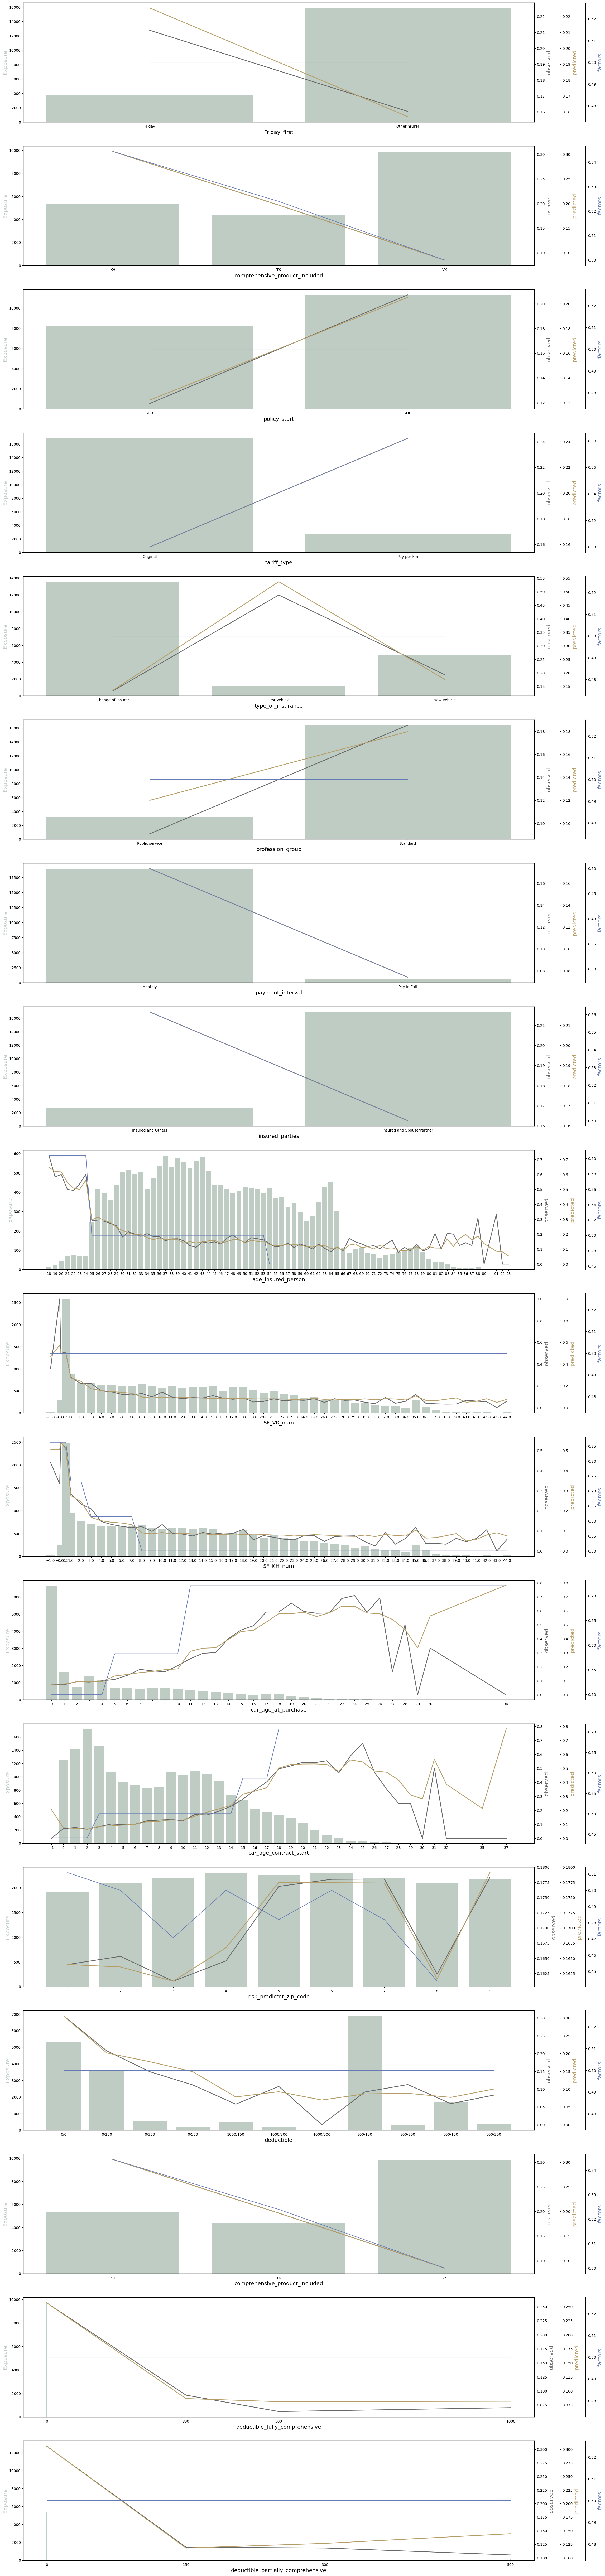

In [4]:
# create a deepcopy of the object
base_model_copy = copy.deepcopy(base_model)

# remove the SF für FC
base_model_copy['ranges'].pop('SF_VK_num')
#base_model_copy['manual_set'].pop('risk_predictor_zip_code')
base_model_copy['manual_set'].pop('deductible')

base_model_copy['dummies'].remove('policy_start')
#base_model_copy['dummies'].remove('tariff_type')
base_model_copy['dummies'].remove('type_of_insurance')
base_model_copy['dummies'].remove('profession_group')
#base_model_copy['dummies'].remove('payment_interval')
#base_model_copy['dummies'].remove('insured_parties')
base_model_copy['dummies'].remove('Friday_first')
base_model_copy['dummies'].append('comprehensive_product_included')



# Try and errors
base_model_copy['ranges']['SF_KH_num']['bins'] = [1,3,8, 999]
base_model_copy['ranges']['age_insured_person']['bins'] = [25, 54, 999]
base_model_copy['ranges']['car_age_contract_start']['bins'] = [3,  15, 18, 999]

base_model_copy['manual_set']['risk_predictor_zip_code']['groups'] = [[1],[2,4,6],[5,7],[3],[8,9]]
#base_model_copy['manual_set']['deductible']['groups'] = [['0/500', '1000/500', '300/300', '500/300', '1000/300', '300/150', '0/150', '0/300'], ['0/0'],['1000/150', '500/150']]



erg2 = build_model(data, column_manager=column_manager, group_file=base_model_copy , tts_list=tts_list )
#print(erg2['model'].summary())


### Split in two , since VSCode keeps bugging
#plot_model_field(erg2, ['Friday_first', 'comprehensive_product_included', 'policy_start','tariff_type', 'type_of_insurance','profession_group','payment_interval','insured_parties'], on_test_data=False)
#plot_model_field(erg2, ['age_insured_person', 'SF_VK_num', 'SF_KH_num','car_age_at_purchase','car_age_contract_start','risk_predictor_zip_code','deductible', 'deductible_fully_comprehensive', 'deductible_partially_comprehensive'], on_test_data=False)


plot_model_field(erg2, ['Friday_first', 'comprehensive_product_included', 'policy_start','tariff_type', 'type_of_insurance','profession_group','payment_interval','insured_parties'
                        ,'age_insured_person', 'SF_VK_num', 'SF_KH_num','car_age_at_purchase','car_age_contract_start','risk_predictor_zip_code','deductible', 'comprehensive_product_included', 'deductible_fully_comprehensive', 'deductible_partially_comprehensive'], on_test_data=False)





In [5]:
print(erg2['model'].summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:          payment_fault   No. Observations:                19562
Model:                            GLM   Df Residuals:                    19542
Model Family:                Binomial   Df Model:                           19
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -6990.8
Date:                Fri, 13 Oct 2023   Deviance:                       13982.
Time:                        22:14:23   Pearson chi2:                 1.93e+04
No. Iterations:                     6   Pseudo R-squ. (CS):             0.1789
Covariance Type:            nonrobust                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -2.7156 

## <font color='#f88231'>Plotting Graphs for the Test Dataset</font>


In [6]:
#base_model
base_model_copy

{'ranges': {'age_insured_person': {'name': 'age_group', 'bins': [25, 54, 999]},
  'SF_KH_num': {'name': 'sf_tpl_group', 'bins': [1, 3, 8, 999]},
  'car_age_at_purchase': {'name': 'car_age_pur_group', 'bins': [5, 11, 999]},
  'car_age_contract_start': {'name': 'car_age_cont_group',
   'bins': [3, 15, 18, 999]}},
 'manual_set': {'risk_predictor_zip_code': {'groups': [[1],
    [2, 4, 6],
    [5, 7],
    [3],
    [8, 9]],
   'name': 'region_group'}},
 'dummies': ['payment_interval',
  'tariff_type',
  'insured_parties',
  'comprehensive_product_included']}

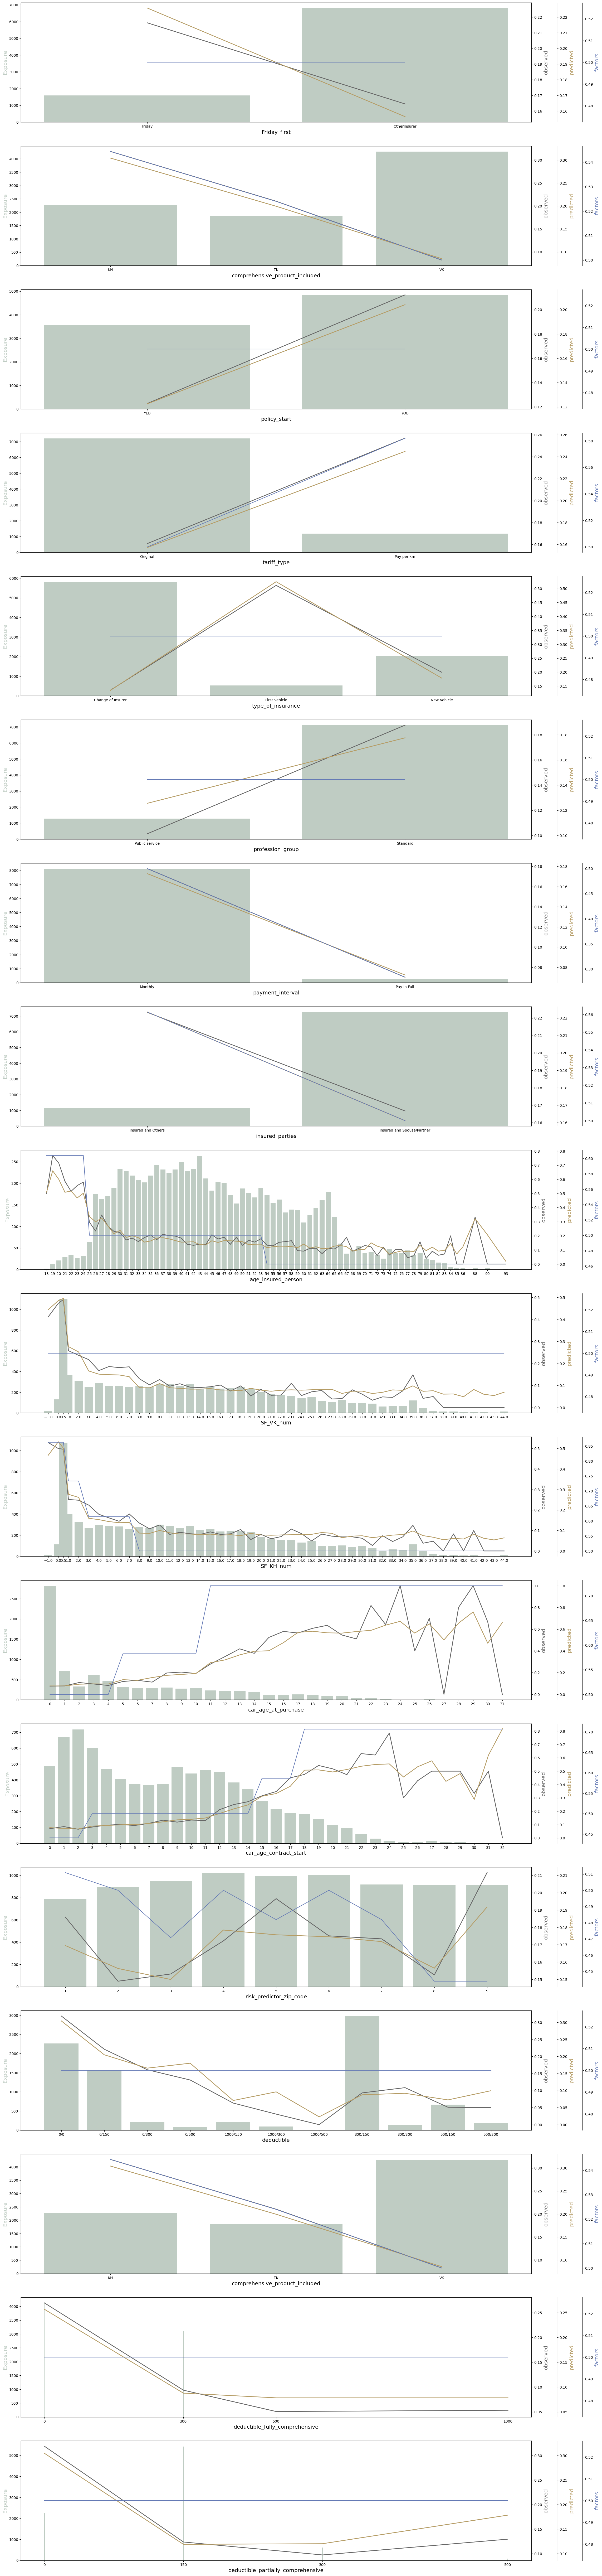

In [7]:
erg3 = build_model(data, column_manager=column_manager, group_file=base_model_copy , tts_list=tts_list )

#print(erg3['model'].summary())

plot_model_field(erg3, ['Friday_first', 'comprehensive_product_included', 'policy_start','tariff_type', 'type_of_insurance','profession_group','payment_interval','insured_parties'
                        ,'age_insured_person', 'SF_VK_num', 'SF_KH_num','car_age_at_purchase','car_age_contract_start','risk_predictor_zip_code','deductible','comprehensive_product_included', 'deductible_fully_comprehensive', 'deductible_partially_comprehensive'], on_test_data=True)




## <font color='#f88231'>Model Scores</font>


In [8]:
# prediction on the test sample
pred_testset = erg3['prediction_testset'][['contract_nr', 'payment_fault', 'predicted']].copy()

# thrashold at 0.5
pred_testset['predicted_tf'] = pred_testset.predicted.apply(lambda x : np.round(x,0))

print('\n')
# only half have been correctly identified
print('payment_faults', pred_testset.payment_fault.sum())
print('predicted_tf', pred_testset.predicted.sum())

print('accuracy: \t', np.round(accuracy_score(pred_testset['payment_fault'], pred_testset['predicted_tf']),4))
print('F1: \t\t', np.round(f1_score(pred_testset['payment_fault'], pred_testset['predicted_tf']),4))

print('roc_auc_score: \t', np.round(roc_auc_score(pred_testset['payment_fault'], pred_testset['predicted_tf']),4))

display(confusion_matrix(pred_testset['payment_fault'], pred_testset['predicted_tf']))



payment_faults 1462
predicted_tf 1421.820399647361
accuracy: 	 0.8527
F1: 		 0.4379
roc_auc_score: 	 0.6462


array([[6668,  254],
       [ 981,  481]], dtype=int64)

In [9]:
auc = roc_auc_score(y_test['payment_fault'], pred_testset['predicted'])
fpr, tpr,_ = roc_curve(y_test['payment_fault'], pred_testset['predicted'])

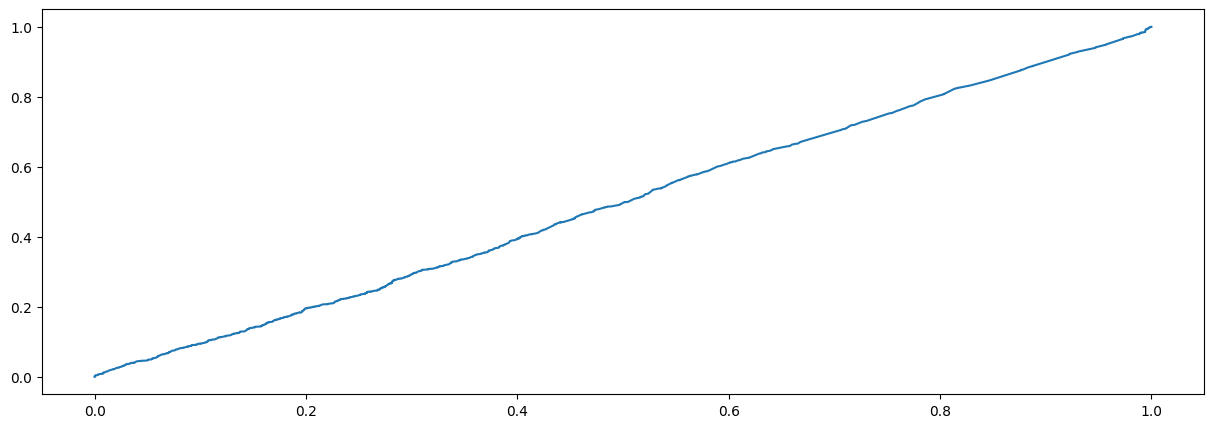

In [10]:
import matplotlib.pyplot as plt

plt.plot(fpr, tpr)

## <font color='#f88231'>Random Forrest as alternative (on the same data)</font>
Usually this would include a list of many classifiers that would be testet on the Data with different settings for each.
The most promising one would then be modeled out.  


In [11]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(max_depth=3, random_state=42)
rfc.fit(erg3['md'][1], erg3['md'][3].reset_index())

RandomForestClassifier(max_depth=3, random_state=42)

In [12]:
prediction = pd.DataFrame(rfc.predict(erg3['md'][2]))
truth = erg3['md'][4]


In [13]:


print('payment_faults', truth['payment_fault'].sum())
print('predicted_tf', prediction[1].sum())

print('accuracy: \t', np.round(accuracy_score(truth['payment_fault'],prediction[1]),4))
print('F1: \t\t', np.round(f1_score(truth['payment_fault'],prediction[1]),4))

print('roc_auc_score: \t', np.round(roc_auc_score(erg3['md'][4],prediction[1]),4))

display(confusion_matrix(erg3['md'][4],prediction[1]))




payment_faults 1462
predicted_tf 208
accuracy: 	 0.838
F1: 		 0.1868
roc_auc_score: 	 0.5496


array([[6870,   52],
       [1306,  156]], dtype=int64)

In [14]:
tn, fp, fn, tp = confusion_matrix(erg3['md'][4],prediction[1]).ravel()
print(tn, tp, fp, fn)

#6875 145 47 1317

6870 156 52 1306


## <font color='#f88231'>Export for Power Bi</font>


In [15]:
preds =pd.DataFrame(erg2['model'].predict(erg2['md'][0])).reset_index()
preds.to_csv('./data/predictions/predictions_all_policies.csv', sep=';', index=False)


preds =pd.DataFrame(erg2['model'].predict(erg2['md'][2])).reset_index()
preds.to_csv('./data/predictions/predictions_x_test_policies.csv', sep=';', index=False)